<a href="https://colab.research.google.com/github/lg550055/MLpremium/blob/main/MLsalary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Let's see if machine learning expertise leads to a salary premium
We'll first import the libraries and the data, which we will then clean

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
df = pd.read_csv('https://download.data.world/s/3twunbcbeb7bvq5xgb2za5dd3ymzg4')
df.head()

,q1,q4,q5,q6,q8,q15,q20,q24
0,30-34,Master’s degree,Data Engineer,5-10 years,Python,1-2 years,"10,000 or more employees","100,000-124,999"
1,30-34,Master’s degree,Data Scientist,5-10 years,Python,3-4 years,250-999 employees,"125,000-149,999"
2,35-39,Doctoral degree,Research Scientist,1-2 years,R,Under 1 year,0-49 employees,"30,000-39,999"
3,50-54,Master’s degree,Software Engineer,20+ years,Python,1-2 years,50-249 employees,"150,000-199,999"
4,25-29,Master’s degree,Student,1-2 years,Python,1-2 years,NaN,NaN


Clean the data: i. remove q5 and q8 columns and insert meaningful table headings, ii. convert text of columns to numbers, and  iii. eliminate empty (or NaN) entries.

In [3]:
df = df.drop(columns=["q8",'q5'])
df = df.rename(columns={"q1": "age", "q4": "degree", "q6":"codExperience", "q15":"MLexperience", "q20":"coSize", "q24":"salary"})
df.describe()

,age,degree,codExperience,MLexperience,coSize,salary
count,2237,2221,2183,1950,1550,1484
unique,11,7,7,9,5,25
top,30-34,Master’s degree,3-5 years,Under 1 year,"10,000 or more employees","100,000-124,999"
freq,398,1046,509,474,447,249


In [4]:
# exludes ranges under 40k, which are well below market
mapSalary = {'100,000-124,999':112, '125,000-149,999':132, '150,000-199,999':175, '70,000-79,999':75, '50,000-59,999':55, '> $500,000':555,
          '250,000-299,999':275, '60,000-69,999':65, '80,000-89,999':85, '300,000-500,000':400, '40,000-49,999':45, '200,000-249,999':225, '90,000-99,999':95}
df['salary'] = df['salary'].map(mapSalary)

mapCexp = {'5-10 years':7.5, '20+ years':22, '1-2 years':1.5, '10-20 years':15, '3-5 years':4, '< 1 years':0.5}
df['codExperience'] = df['codExperience'].map(mapCexp)

mapMLexp = {'1-2 years':1.5, '3-4 years':3.5, 'Under 1 year':0.5, '5-10 years':7.5, '2-3 years': 2.5, '4-5 years':4.5, '20 or more years':22, '10-20 years':15}
df['MLexperience'] = df['MLexperience'].map(mapMLexp)

mapAge = {'30-34':32, '50-54':52, '35-39':37, '45-49':47, '25-29':27, '40-44':42, '60-69':64.5, '22-24':23, '55-59':57, '70':70, '18-21':19.5}
df['age'] = df['age'].map(mapAge)

mapDegree = {'Master’s degree':1.5, 'Doctoral degree':2, 'Bachelor’s degree':0.5, 'Some college/university study without earning a bachelor’s degree':0, 'Professional degree':1}
df['degree'] = df['degree'].map(mapDegree)

mapCo = {'10,000 or more employees':2, '250-999 employees':1.5, '50-249 employees':1.25, '0-49 employees':1, '1000-9,999 employees':1.75}
df['coSize'] = df['coSize'].map(mapCo)

In [5]:
# delete rows with non meaningful entries in selected columns
df.dropna(subset=['salary','MLexperience','codExperience','degree'], inplace=True)
df.describe()

,age,degree,codExperience,MLexperience,coSize,salary
count,1087.000000,1087.000000,1087.000000,1087.000000,1087.000000,1087.000000
mean,39.840846,1.353266,10.774609,4.466421,1.574287,141.425943
std,11.633858,0.566357,7.466394,5.003178,0.383162,81.517094
min,19.500000,0.000000,0.500000,0.500000,1.000000,45.000000
25%,32.000000,1.000000,4.000000,1.500000,1.250000,95.000000
50%,37.000000,1.500000,7.500000,2.500000,1.750000,112.000000
75%,47.000000,1.500000,15.000000,4.500000,2.000000,175.000000
max,70.000000,2.000000,22.000000,22.000000,2.000000,555.000000


### Plot the data to see if there are readily observable patterns

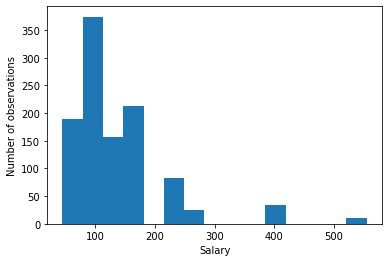

In [6]:
# Salary histogram of all data
x = df['salary']
plt.hist(x,15)
plt.xlabel('Salary')
plt.ylabel('Number of observations')
plt.show()

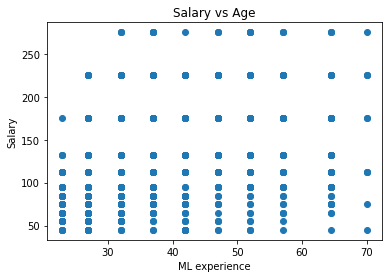

In [7]:
adjData = df.loc[(df['age'] > 20) & (df['salary'] < 300)]
plt.scatter(adjData['age'], adjData['salary'])
plt.title('Salary vs Age')
plt.xlabel('ML experience')
plt.ylabel('Salary')
plt.show()

There does not seem to be a clear link between salaty and age.

#### Let's see if there is a machine learning premium by comparing the salary of programmers with 4 years of experience by years of ML experience

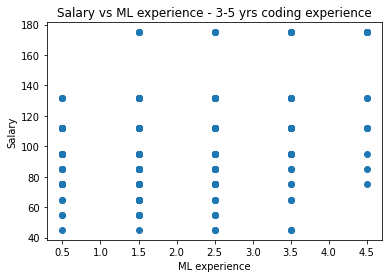

In [8]:
# Excludes salaries > 200k to increase the resolution, without affecting the general conclusion
x4 = df.loc[(df['codExperience'] == 4) & (df['salary'] < 200)]
plt.scatter(x4['MLexperience'],x4['salary'])
plt.title('Salary vs ML experience - 3-5 yrs coding experience')
plt.xlabel('ML experience')
plt.ylabel('Salary')
plt.show()

There also seems to be a slight ML experience salary premium.

Let's see if this is also the case for for programmers with 7.5 years of experience.

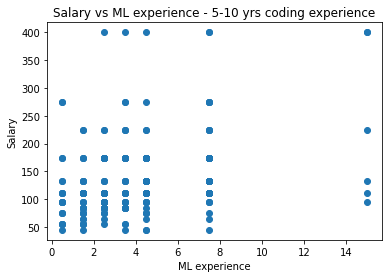

In [9]:
x2 = df.loc[df['codExperience'] == 7.5]
plt.scatter(x2['MLexperience'],x2['salary'])
plt.title('Salary vs ML experience - 5-10 yrs coding experience')
plt.xlabel('ML experience')
plt.ylabel('Salary')
plt.show()

### Let's use a ML model to see if we can better acertain if there is a ML salary premium

In [10]:
# segment data into training and test sets
train_data = df.sample(frac=0.8, random_state=0)
test_data = df.drop(train_data.index)

# split features from labels
train_features = train_data.copy()
test_features = test_data.copy()

train_labels = train_features.pop('salary')
test_labels = test_features.pop('salary')

In [11]:
# Use normalization layer to prevent the scale of the inputs from affecting the gradient and output scale.
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(train_features)

In [12]:
model = tf.keras.Sequential([
  normalizer,
  tf.keras.layers.Dense(1)
])

In [41]:
# Use mean_absolute_error to lower sensitivity to outliers
model.compile(loss='mean_absolute_error',
              optimizer=tf.keras.optimizers.Adam(0.4))

In [42]:
history = model.fit(train_features, train_labels, epochs=15, validation_split = 0.2)

Epoch 1/15
22/22 [==============================] - 0s 9ms/step - loss: 47.1109 - val_loss: 41.8783
Epoch 2/15
22/22 [==============================] - 0s 3ms/step - loss: 47.0422 - val_loss: 41.9078
Epoch 3/15
22/22 [==============================] - 0s 4ms/step - loss: 47.0856 - val_loss: 41.9765
Epoch 4/15
22/22 [==============================] - 0s 3ms/step - loss: 47.0299 - val_loss: 41.8988
Epoch 5/15
22/22 [==============================] - 0s 3ms/step - loss: 47.0970 - val_loss: 41.8576
Epoch 6/15
22/22 [==============================] - 0s 3ms/step - loss: 47.0657 - val_loss: 41.9252
Epoch 7/15
22/22 [==============================] - 0s 5ms/step - loss: 47.0425 - val_loss: 41.8976
Epoch 8/15
22/22 [==============================] - 0s 4ms/step - loss: 47.0502 - val_loss: 41.9729
Epoch 9/15
22/22 [==============================] - 0s 3ms/step - loss: 47.0748 - val_loss: 41.9488
Epoch 10/15
22/22 [==============================] - 0s 5ms/step - loss: 47.0803 - val_loss: 41.9666

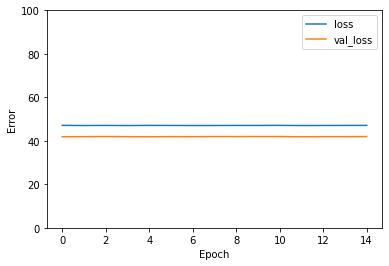

In [44]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.show()

In [45]:
model.layers[1].kernel

<tf.Variable 'dense/kernel:0' shape=(5, 1) dtype=float32, numpy=
array([[ 5.1657934],
       [ 2.257345 ],
       [ 8.111115 ],
       [19.661709 ],
       [ 3.2038445]], dtype=float32)>

In [46]:
model.evaluate(test_features, test_labels, verbose=0)

52.54296875

Let's see if we get improvement from using a additional layers

In [18]:
dnn_model = tf.keras.Sequential([
  normalizer,
  tf.keras.layers.Dense(5),
  tf.keras.layers.Dense(5),
  tf.keras.layers.Dense(1)
])

In [33]:
dnn_model.compile(loss='mean_absolute_error',
              optimizer=tf.keras.optimizers.Adam(0.1))

In [34]:
dnn_history = dnn_model.fit(train_features, train_labels, epochs=5, validation_split = 0.2)

Epoch 1/5
22/22 [==============================] - 1s 11ms/step - loss: 50.7747 - val_loss: 44.6953
Epoch 2/5
22/22 [==============================] - 0s 4ms/step - loss: 48.6608 - val_loss: 42.3596
Epoch 3/5
22/22 [==============================] - 0s 4ms/step - loss: 47.9335 - val_loss: 43.3585
Epoch 4/5
22/22 [==============================] - 0s 5ms/step - loss: 47.7590 - val_loss: 42.3931
Epoch 5/5
22/22 [==============================] - 0s 4ms/step - loss: 47.9143 - val_loss: 43.3801


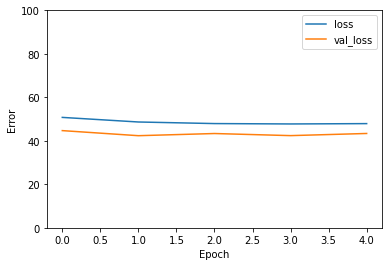

In [35]:
plt.plot(dnn_history.history['loss'], label='loss')
plt.plot(dnn_history.history['val_loss'], label='val_loss')
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.show()

In [36]:
dnn_model.layers[3].kernel

<tf.Variable 'dense_3/kernel:0' shape=(5, 1) dtype=float32, numpy=
array([[-1.3767794],
       [-1.4258554],
       [ 1.2873094],
       [ 1.7933547],
       [ 1.5174987]], dtype=float32)>

In [37]:
dnn_model.evaluate(test_features, test_labels, verbose=0)

52.35432052612305

#### Predictions
Since there does not seem to be a significant difference between the one-layer model and the three-layer, we'll use the one-layer to make predictions on the test set

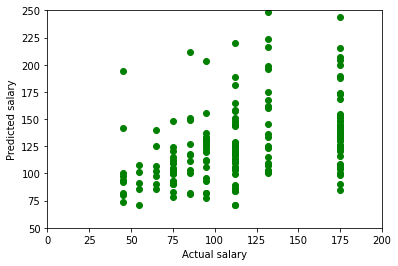

In [38]:
predictions = dnn_model.predict(test_features)
plt.scatter(test_labels, predictions, c='green')
plt.xlabel('Actual salary')
plt.ylabel('Predicted salary')
plt.xlim([0, 200])
plt.ylim([50, 250])
plt.show()

### Conclusion: The dataset makes it hard to draw definitive conclusions.  However, there seems to be a sligh premium to ML expertise
